In [1]:
! pip install -q kaggle

In [2]:
!nvidia-smi

Thu Jun 17 06:29:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arkaprabhabasu","key":"8112242df80318862ad34b6e5d0ba05c"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:28<00:00, 62.0MB/s]
100% 2.29G/2.29G [00:29<00:00, 84.6MB/s]


In [ ]:
!unzip "/content/chest-xray-pneumonia.zip"

In [10]:
from fastai.vision import *
import glob
import shutil

In [11]:
%cd /content/chest_xray/train/

/content/chest_xray/train


In [12]:
!mv PNEUMONIA BACTERIA
!mkdir VIRUS

In [13]:
files=glob.glob("/content/chest_xray/train/BACTERIA/*.jpeg")
for file in files:
  if 'virus' in file:
    shutil.move(file,"/content/chest_xray/train/VIRUS")

In [14]:
len(files)

3875

In [15]:
virusfiles=glob.glob("/content/chest_xray/train/VIRUS/*.jpeg")
len(virusfiles)

1345

In [17]:
%cd /content/chest_xray/val/
!mv PNEUMONIA BACTERIA
!mkdir VIRUS
files=glob.glob("/content/chest_xray/val/BACTERIA/*.jpeg")
for file in files:
  if 'virus' in file:
    shutil.move(file,"/content/chest_xray/test/VIRUS")
print(len(files))

/content/chest_xray/val
8


In [18]:
virusfiles=glob.glob("/content/chest_xray/test/VIRUS/*.jpeg")
len(virusfiles)

148

In [20]:
files=glob.glob("/content/chest_xray/val/BACTERIA/*.jpeg")
virusfiles=glob.glob("/content/chest_xray/test/BACTERIA/*.jpeg")
len(virusfiles)
for file in files:
  if 'bacteria' in file:
    shutil.move(file,"/content/chest_xray/test/BACTERIA")
print(len(files))
virusfiles=glob.glob("/content/chest_xray/test/BACTERIA/*.jpeg")
len(virusfiles)
virusfiles=glob.glob("/content/chest_xray/test/VIRUS/*.jpeg")
len(virusfiles)

0


148

In [21]:
from fastai.vision import *
import warnings
warnings.filterwarnings('ignore')

In [22]:
data_path=Path('/content/chest_xray').absolute()
model_path=Path('/content/model').absolute()

In [23]:
data=ImageDataBunch.from_folder(data_path,
                                valid="test",
                                size=256,
                                ds_tfms=get_transforms(),
                                ).normalize(imagenet_stats)

In [24]:
print(data.classes,len(data.train_ds),len(data.valid_ds))

['BACTERIA', 'NORMAL', 'VIRUS'] 5216 632


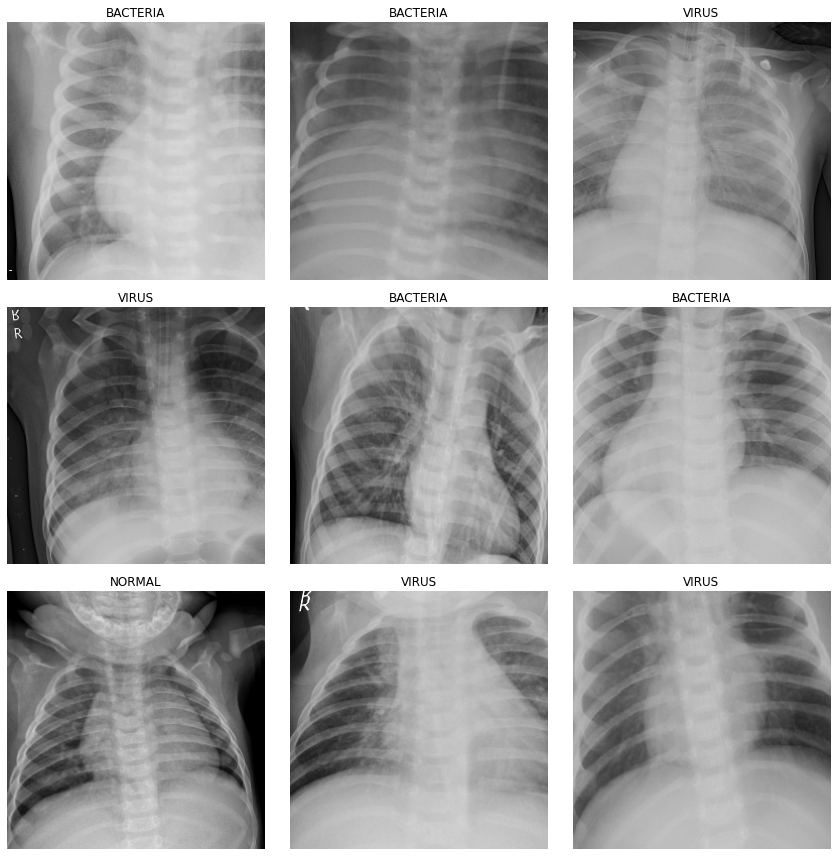

In [25]:
data.show_batch(rows=3)

In [26]:
learn=cnn_learner(data,
                  models.resnet50,
                  metrics=error_rate,
                  model_dir=model_path)
learn.fit_one_cycle(5)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.042289,0.981529,0.276899,04:00
1,0.723154,0.730484,0.210443,04:04
2,0.598761,0.631010,0.204114,04:05
3,0.516349,0.619242,0.185127,04:02
4,0.489822,0.572835,0.177215,04:03


In [27]:
learn.unfreeze()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


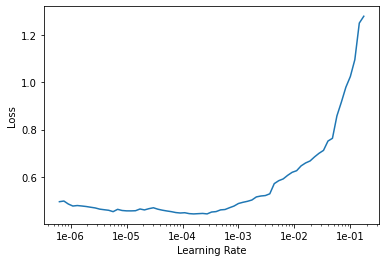

In [29]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(5, max_lr=3e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.492761,0.731557,0.200949,04:02
1,0.492012,0.745854,0.223101,04:00
2,0.442492,0.521286,0.169304,04:00
3,0.394561,0.372278,0.113924,04:00
4,0.340397,0.413428,0.120253,04:01


In [32]:
learn.export(model_path / 'export.pkl')
learn.save(model_path / 'pneumonia')

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
!cp "/content/model/export.pkl" '/content/drive/MyDrive/3_class_fastai'

In [ ]:
# Save the model
learn.save('stage-1')

# Load the Model
learn.load('stage-1')

In [37]:
# Build a Classification Interpretation object from our learn model
interp = ClassificationInterpretation.from_learner(learn)

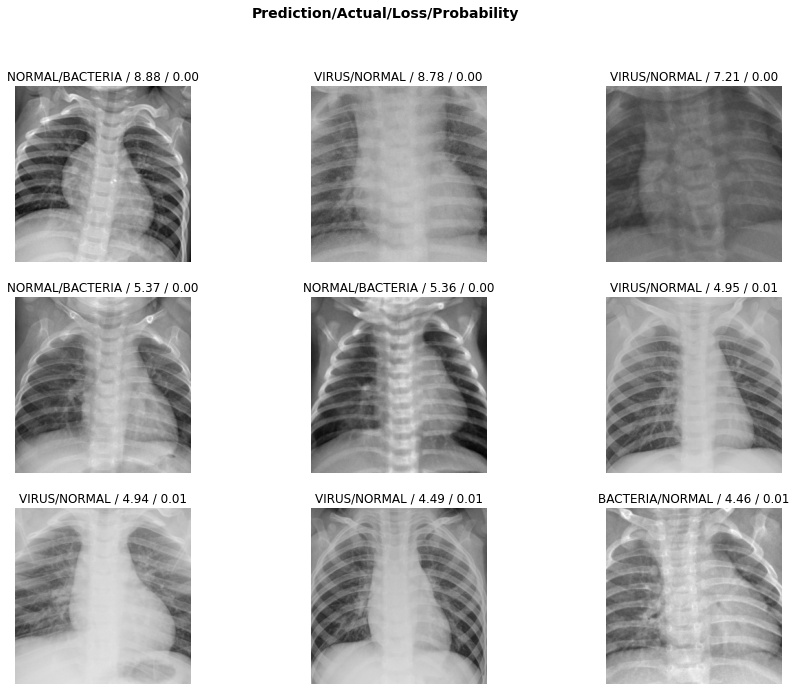

In [38]:
# Show top 9 images with the highest loss
interp.plot_top_losses(9, figsize=(15,11))

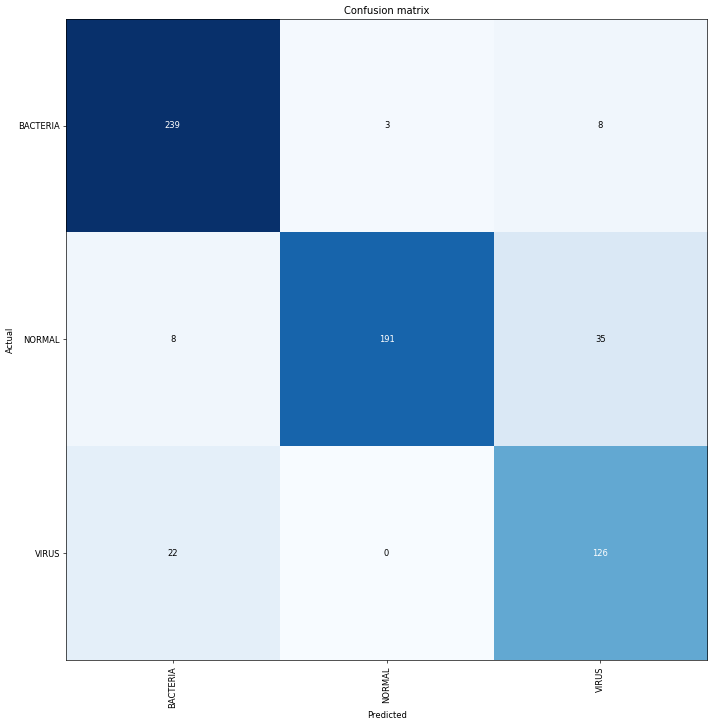

In [39]:
# Build a confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [40]:
# Build a text version of a confusion matrix-- really helpful with a lot of classes
interp.most_confused(min_val=2)

[('NORMAL', 'VIRUS', 35),
 ('VIRUS', 'BACTERIA', 22),
 ('BACTERIA', 'VIRUS', 8),
 ('NORMAL', 'BACTERIA', 8),
 ('BACTERIA', 'NORMAL', 3)]

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 3.98E-07


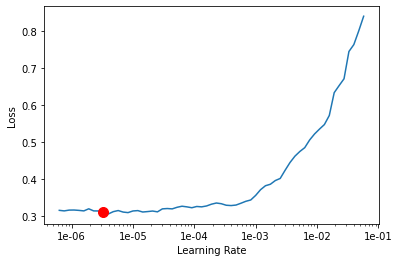

In [41]:
learn.unfreeze()

# Find the optimal learning rate and plot a visual
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [42]:
# Fit the model over 2 epochs
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.327021,0.425631,0.128165,03:58
1,0.314044,0.402416,0.118671,03:57


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-04
Min loss divided by 10: 6.31E-08


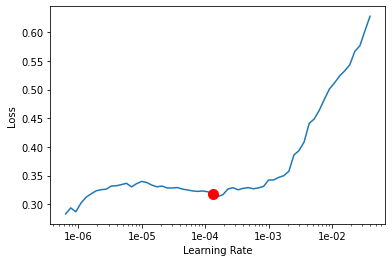

In [43]:
# See if optimal learning rate changes
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [45]:
# Save the model
learn.save('stage-2')

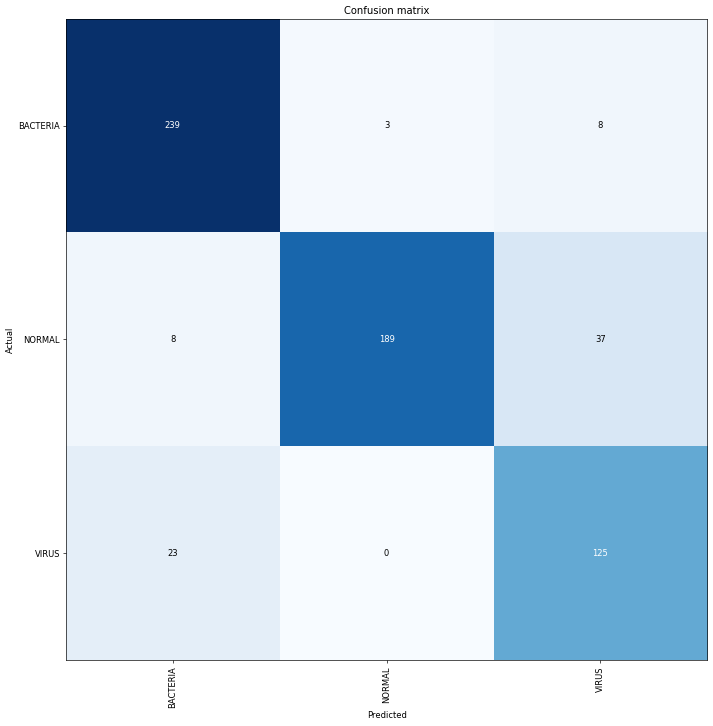

In [46]:
# Rebuild interpreter and replot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

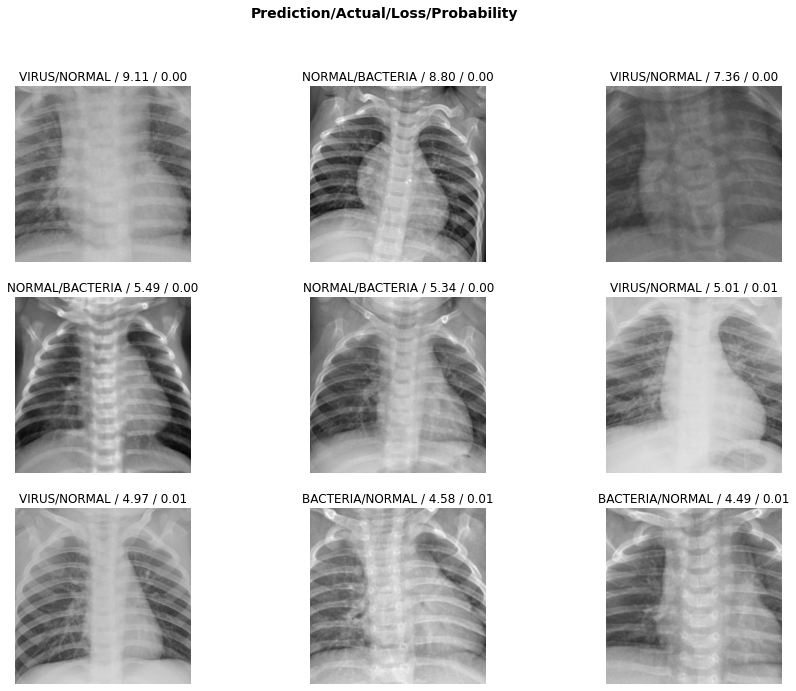

In [47]:
# Show top 9 images with the highest loss
interp.plot_top_losses(9, figsize=(15,11))

In [48]:
# Build a text version of a confusion matrix-- really helpful with a lot of classes
interp.most_confused(min_val=2)

[('NORMAL', 'VIRUS', 37),
 ('VIRUS', 'BACTERIA', 23),
 ('BACTERIA', 'VIRUS', 8),
 ('NORMAL', 'BACTERIA', 8),
 ('BACTERIA', 'NORMAL', 3)]

In [49]:
print(model_path)
learn.export(model_path / 'export.pkl')
learn.save(model_path / 'pneumonia')

/content/model


In [50]:
!cp "/content/model/export.pkl" '/content/drive/MyDrive/3_class_fastai'

In [51]:
from fastai.callbacks.hooks import *

In [52]:
#learn=load_learner("..")
learn=load_learner("/content/drive/MyDrive/3_class_fastai")
model=learn.model.eval()

In [99]:
'''import cv2
image=cv2.imread("/content/chest_xray/test/BACTERIA/person100_bacteria_482.jpeg")
print(image.shape)
image=cv2.resize(image,(256,256))
print(image.shape)'''
img=open_image("/content/C15sharpClaheG15a1c8a30b-9978-4be6-9be1-d55456ef2480.png")

In [100]:
pred=learn.predict(img)
cls=int(pred[1])
pred,cls

((Category tensor(2), tensor(2), tensor([0.2695, 0.2435, 0.4869])), 2)

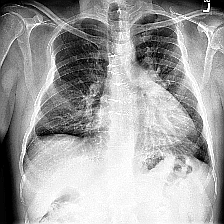

In [101]:
b, _ =learn.data.one_item(img,denorm=False)
#b = Image(data.one_item(img,denorm=True))
#b=b.cuda()
img

In [102]:
with hook_output(model[0]) as hook_a:
  with hook_output(model[0],grad=True) as hook_g:
    preds=model(b)
    preds[0,cls].backward()
acts=hook_a.stored[0].cpu()
grad=hook_g.stored[0][0].cpu()

In [103]:
grad_chan=grad.mean(1).mean(1)
mult=((acts*grad_chan[..., None, None])).sum(0)

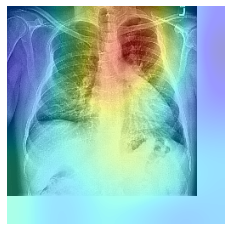

In [104]:
_, ax=plt.subplots()
img.show(ax)
ax.imshow(mult, alpha=0.4, extent=(0,256,256,0), interpolation='bicubic', cmap='jet')